In [2]:
! pip install plotly
! pip install folium

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/18/09/8569904c8ce5679cc02826d98de633c07abcd2443a23181e5f71ff9dacbc/folium-0.15.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/17/ce/14166d0e273d12065516625fb02426350298e7b4ba59198b5fe454b46202/branca-0.7.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/97.0 kB ? eta -:--:--
   ---------------------------------------- 97.0/97.0 kB 2.8 MB/s eta 0:00:00


In [3]:
# import pandas for structuring the data
import pandas as pd

# import numpy for numerical analysis
import numpy as np

# import libs for diagrams inline with the text
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# other utilities
from sklearn import datasets, preprocessing, metrics

In [4]:
# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

# for diagramming 
import matplotlib.pyplot as plt
import seaborn as sns

# For serialization and deserialization of data from/to file
import pickle

In [5]:
import folium

In [7]:
# read the json file from your data folder into a data frame
#df = pd.read_csv(r'C:\Users\chz\Documents\BI Exercise\\BI Exam\global air pollution dataset.csv')
df = pd.read_csv(r'DataSæt\global air pollution dataset.csv')

In [6]:
df.columns

Index(['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value',
       'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category',
       'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value',
       'PM2.5 AQI Category'],
      dtype='object')

In [7]:
df.shape

(23463, 12)

In [8]:
df.isnull().sum()

Country               427
City                    1
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
dtype: int64

In [9]:
# Remove rows with missing 'Country' and  'cities' values and create a cleaned DataFrame
df_cleaned = df.dropna(subset=['Country', 'City'])

In [10]:
df_cleaned.isnull().sum()

Country               0
City                  0
AQI Value             0
AQI Category          0
CO AQI Value          0
CO AQI Category       0
Ozone AQI Value       0
Ozone AQI Category    0
NO2 AQI Value         0
NO2 AQI Category      0
PM2.5 AQI Value       0
PM2.5 AQI Category    0
dtype: int64

In [11]:
df = df_cleaned

In [12]:
df.isnull().sum()

Country               0
City                  0
AQI Value             0
AQI Category          0
CO AQI Value          0
CO AQI Category       0
Ozone AQI Value       0
Ozone AQI Category    0
NO2 AQI Value         0
NO2 AQI Category      0
PM2.5 AQI Value       0
PM2.5 AQI Category    0
dtype: int64

In [13]:
df.sample(50)

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
17646,Kyrgyzstan,At Bashi,66,Moderate,0,Good,38,Good,0,Good,66,Moderate
7893,Japan,Kitakyushu,49,Good,1,Good,49,Good,1,Good,37,Good
7773,Germany,Forst,38,Good,1,Good,18,Good,6,Good,38,Good
15619,United States of America,Jericho,76,Moderate,2,Good,13,Good,26,Good,76,Moderate
19518,Italy,Melito Di Porto Salvo,94,Moderate,1,Good,43,Good,0,Good,94,Moderate
4913,Ecuador,Puyo,48,Good,1,Good,3,Good,0,Good,48,Good
10941,Japan,Watari,45,Good,1,Good,45,Good,0,Good,20,Good
15824,Mexico,Bacalar,53,Moderate,1,Good,25,Good,0,Good,53,Moderate
310,United States of America,Cimarron Hills,73,Moderate,1,Good,32,Good,2,Good,73,Moderate
12996,Iran (Islamic Republic of),Falavarjan,129,Unhealthy for Sensitive Groups,1,Good,129,Unhealthy for Sensitive Groups,1,Good,116,Unhealthy for Sensitive Groups


In [14]:
denmark_df = df[df['Country'] == 'Denmark']

In [15]:
print(denmark_df)

       Country            City  AQI Value AQI Category  CO AQI Value  \
162    Denmark   Frederikssund         36         Good             1   
1045   Denmark    Greve Strand         39         Good             0   
1357   Denmark        Ringsted         36         Good             0   
1488   Denmark            Nuuk         23         Good             1   
1946   Denmark           Skive         38         Good             0   
2213   Denmark        Birkerod         36         Good             1   
2241   Denmark        Vaerlose         36         Good             1   
2249   Denmark     Espergaerde         36         Good             1   
2537   Denmark         Thisted         46         Good             0   
2581   Denmark          Struer         43         Good             0   
2787   Denmark     Bronderslev         54     Moderate             0   
2952   Denmark           Ikast         42         Good             1   
3279   Denmark       Svendborg         38         Good          

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23035 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23035 non-null  object
 1   City                23035 non-null  object
 2   AQI Value           23035 non-null  int64 
 3   AQI Category        23035 non-null  object
 4   CO AQI Value        23035 non-null  int64 
 5   CO AQI Category     23035 non-null  object
 6   Ozone AQI Value     23035 non-null  int64 
 7   Ozone AQI Category  23035 non-null  object
 8   NO2 AQI Value       23035 non-null  int64 
 9   NO2 AQI Category    23035 non-null  object
 10  PM2.5 AQI Value     23035 non-null  int64 
 11  PM2.5 AQI Category  23035 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.3+ MB


In [17]:
df.describe()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,23035.000000,23035.000000,23035.000000,23035.000000,23035.000000
mean,72.344693,1.376254,35.233905,3.084741,68.883482
std,56.360992,1.844926,28.236613,5.281708,55.057396
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,1.000000,21.000000,0.000000,35.000000
50%,55.000000,1.000000,31.000000,1.000000,54.000000
75%,80.000000,1.000000,40.000000,4.000000,79.000000
max,500.000000,133.000000,235.000000,91.000000,500.000000


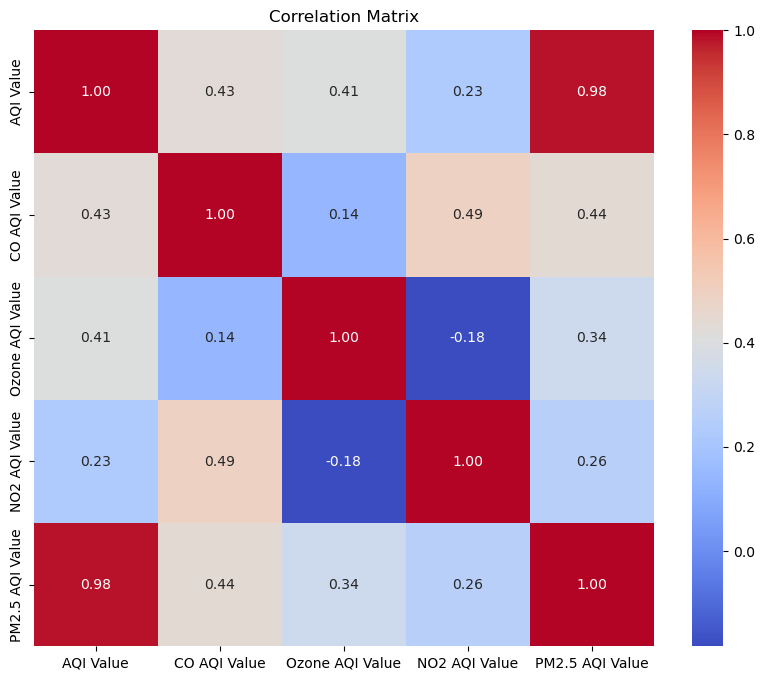

In [18]:
# We have to convert the data from float to int in order to use pandas to calculate the correlations
numeric_df = df.select_dtypes(include=['float64', 'int64'])


df_cleaned = numeric_df.dropna()
# Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<Figure size 1000x600 with 0 Axes>

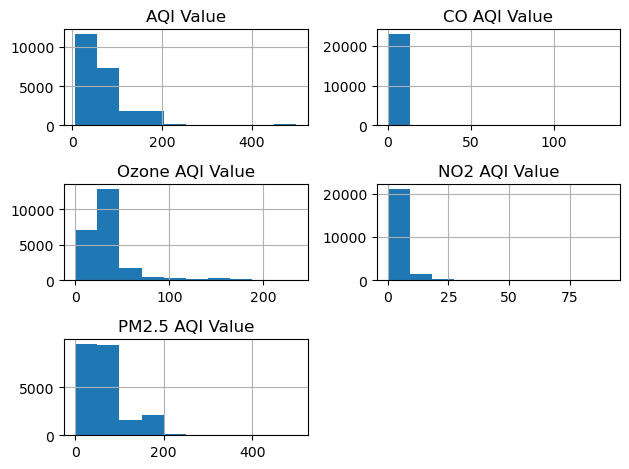

In [19]:
plt.figure(figsize= (10, 6))

# Plot histograms for all columns in the DataFrame
df.hist()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

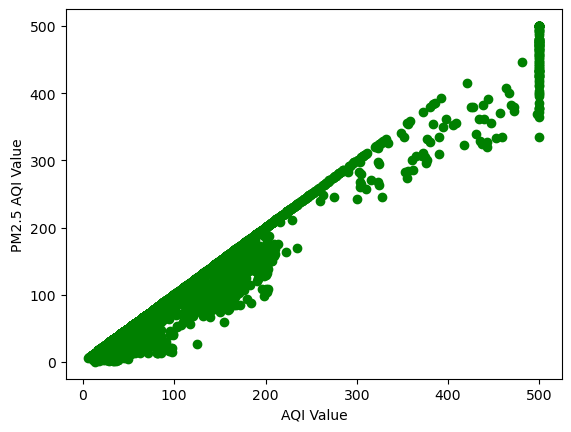

In [20]:
plt.xlabel('AQI Value')
plt.ylabel('PM2.5 AQI Value')
plt.scatter(df['AQI Value'], df['PM2.5 AQI Value'], color='green')
plt.show()

C:\Users\chz\AppData\Local\Temp\ipykernel_2988\1350621379.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['AQI Value'],  label='AQI Value', norm_hist=True)


<Axes: xlabel='AQI Value', ylabel='Density'>

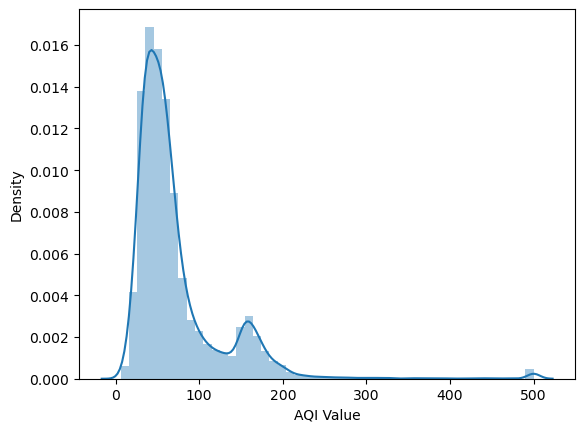

In [21]:
sns.distplot(df['AQI Value'],  label='AQI Value', norm_hist=True)  

C:\Users\chz\AppData\Local\Temp\ipykernel_2988\1301984605.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['PM2.5 AQI Value'],  label='PM2.5 AQI Value', norm_hist=True)


<Axes: xlabel='PM2.5 AQI Value', ylabel='Density'>

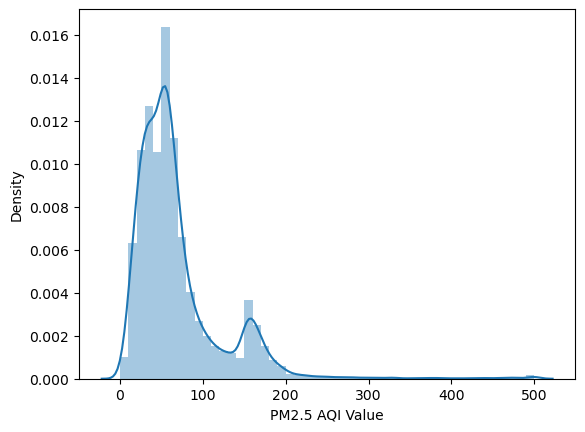

In [22]:
sns.distplot(df['PM2.5 AQI Value'],  label='PM2.5 AQI Value', norm_hist=True) 

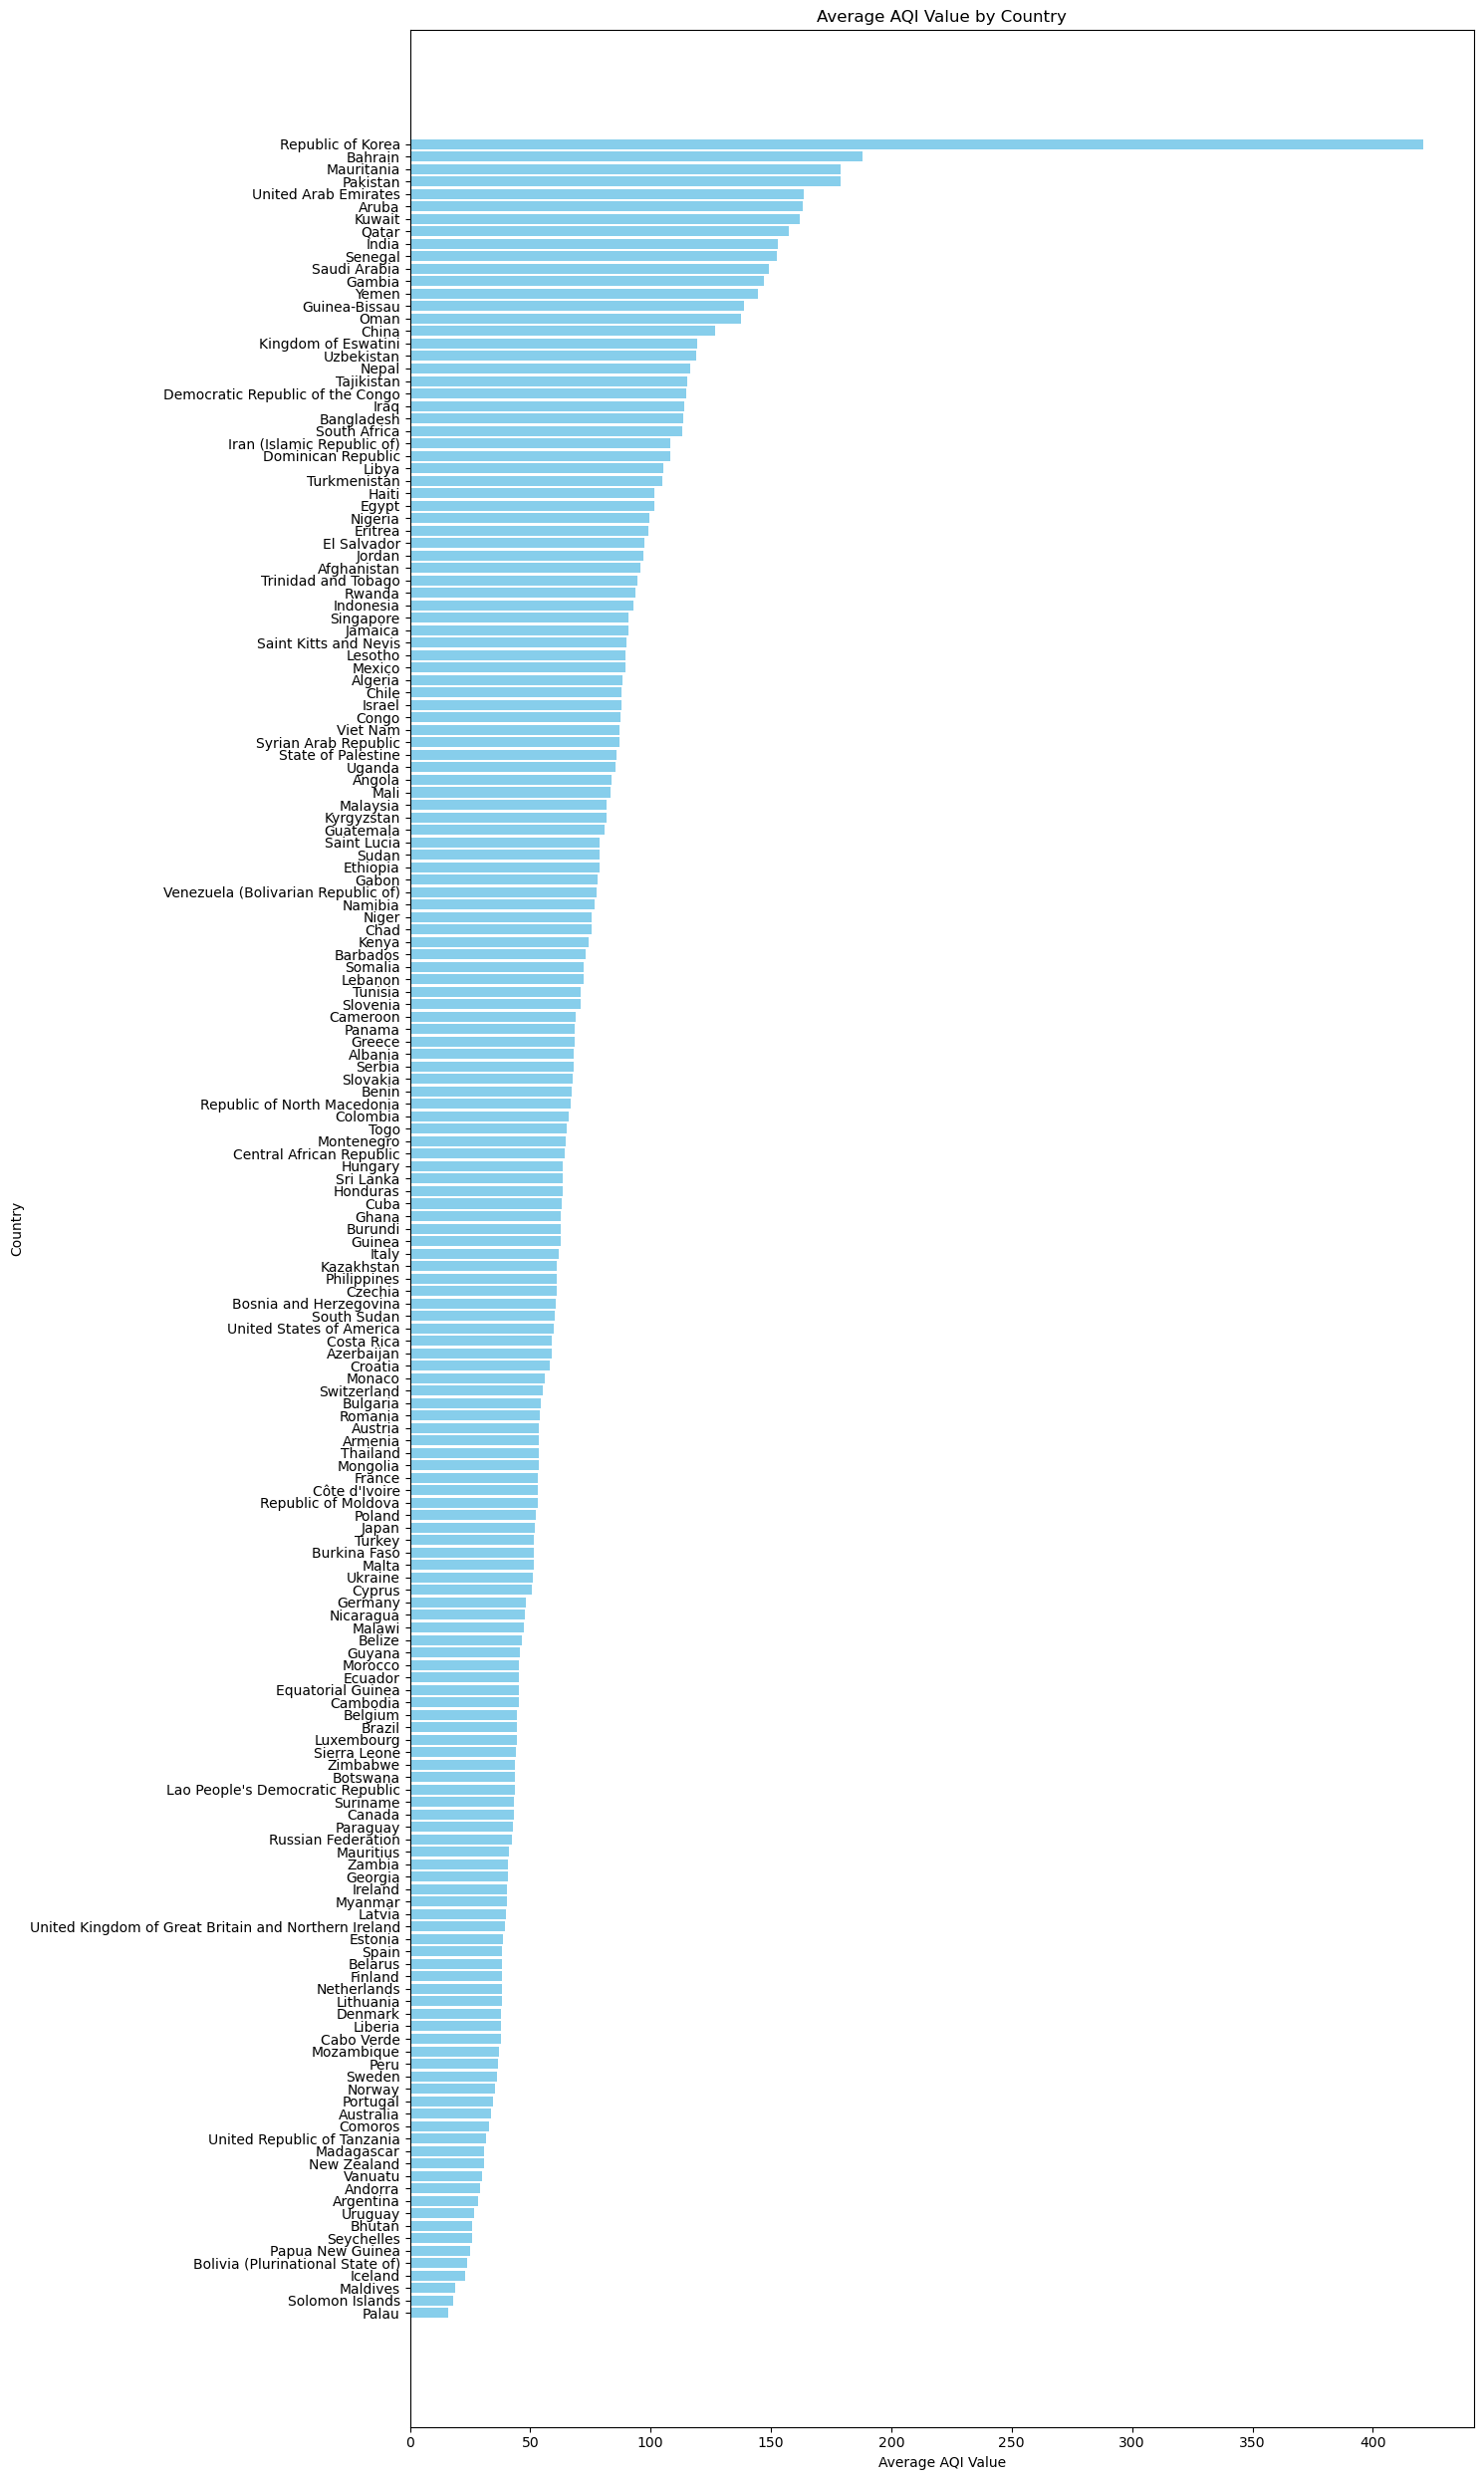

In [23]:
# Grouping the data by 'Country' and calculating the mean 'AQI Value' for each country
country_aqi_means = df.groupby('Country')['AQI Value'].mean()

# Sorting the countries by AQI value for better visualization
country_aqi_means = country_aqi_means.sort_values()

# Creating the bar chart
plt.figure(figsize=(15, 25)) 
plt.barh(country_aqi_means.index, country_aqi_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average AQI Value')
plt.ylabel('Country')
plt.title('Average AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.

plt.show()

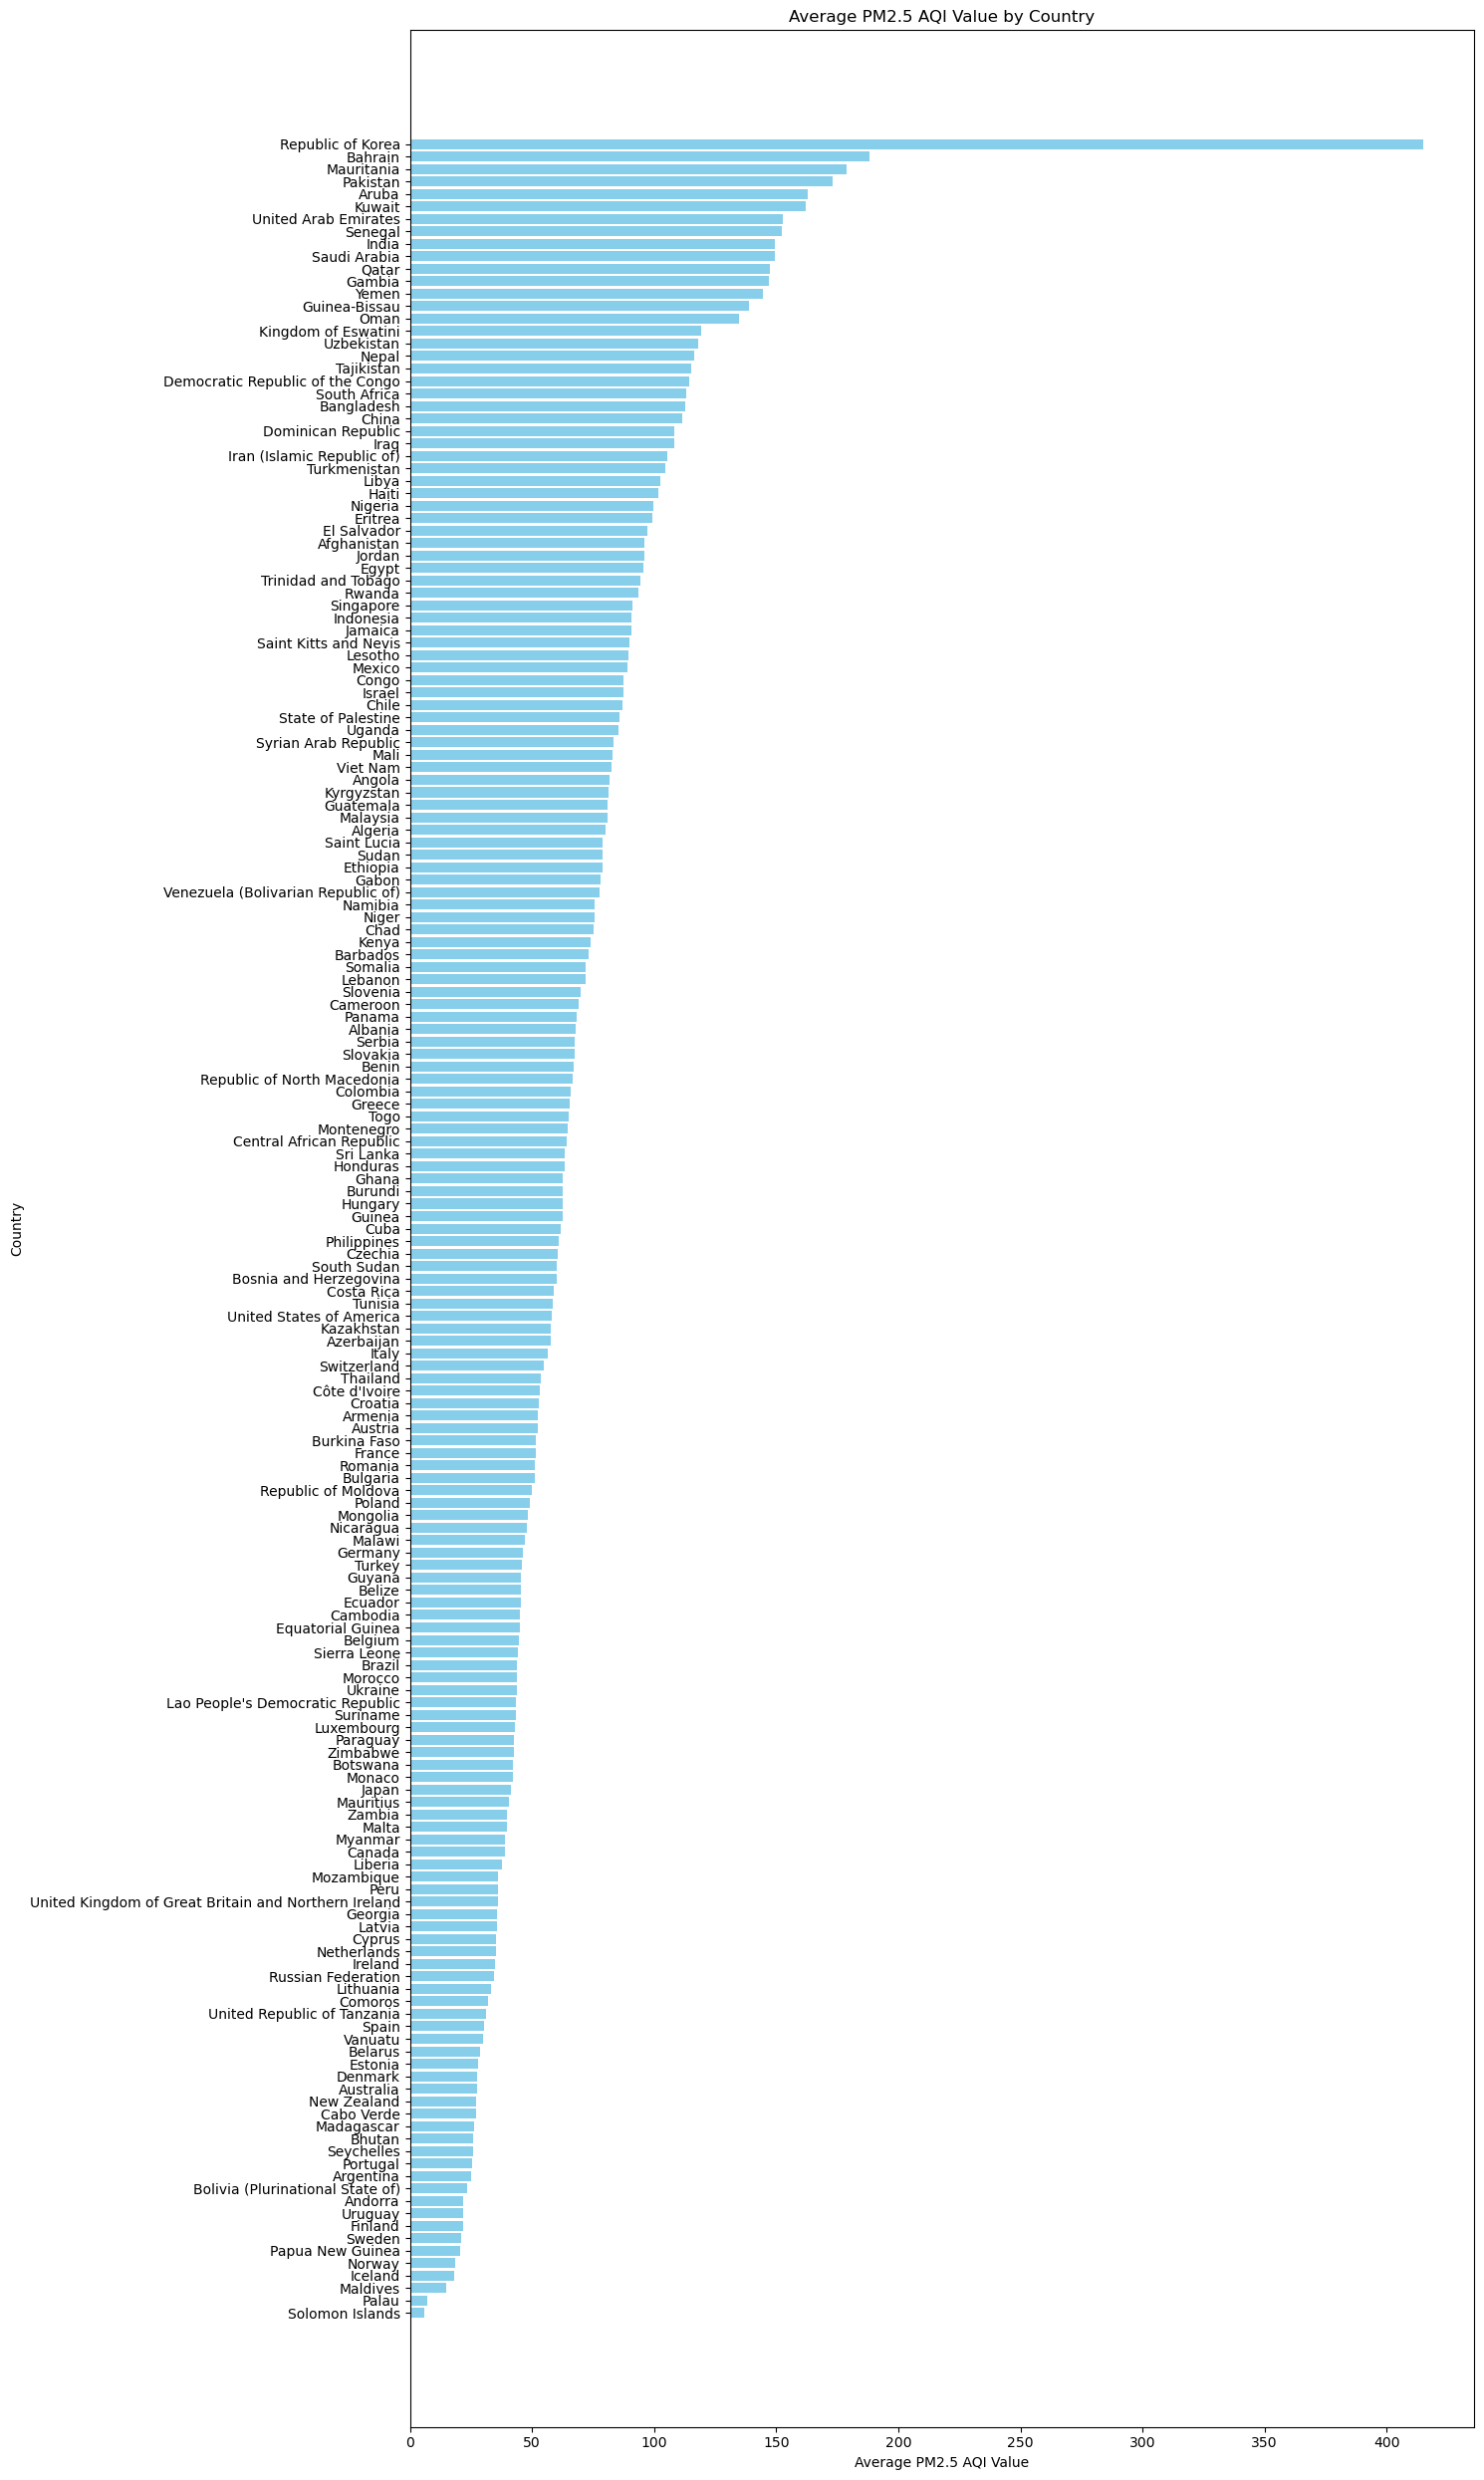

In [8]:
# Grouping the data by 'Country' and calculating the mean 'PM2.5 AQI Value' for each country
country_pm25_means = df.groupby('Country')['PM2.5 AQI Value'].mean()
# Sorting the countries by PM2.5 AQI value for better visualization
country_pm25_means = country_pm25_means.sort_values()
# Creating the bar chart
plt.figure(figsize=(15, 25))
plt.barh(country_pm25_means.index, country_pm25_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average PM2.5 AQI Value')
plt.ylabel('Country')
plt.title('Average PM2.5 AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()


In [9]:
#create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'Country' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='Country', title='AQI Value vs PM2.5 AQI Value')
fig.show()


In [11]:
# divide the data into 5 clusters using the KMeans algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['AQI Value', 'PM2.5 AQI Value']])
df['cluster'] = kmeans.predict(df[['AQI Value', 'PM2.5 AQI Value']])
df.sample(10)



c:\Users\tobia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,cluster
19356,Netherlands,Hengelo,38,Good,1,Good,38,Good,0,Good,32,Good,0
1291,Russian Federation,Kudymkar,43,Good,1,Good,39,Good,0,Good,43,Good,0
11241,Mexico,Ahome,57,Moderate,2,Good,19,Good,2,Good,57,Moderate,4
21964,Benin,Sakete,70,Moderate,1,Good,18,Good,1,Good,70,Moderate,4
23163,United States of America,Dudley,47,Good,1,Good,47,Good,2,Good,46,Good,0
15018,Egypt,Talkha,78,Moderate,1,Good,78,Moderate,2,Good,64,Moderate,4
6096,Italy,Frattaminore,61,Moderate,1,Good,61,Moderate,3,Good,59,Moderate,4
4347,United States of America,Rio Grande City,38,Good,0,Good,23,Good,0,Good,38,Good,0
22802,United States of America,Colorado Springs,68,Moderate,1,Good,20,Good,6,Good,68,Moderate,4
13446,Italy,Alassio,56,Moderate,1,Good,35,Good,3,Good,56,Moderate,4


In [12]:
# create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'cluster' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='cluster', title='AQI Value vs PM2.5 AQI Value')
fig.show()
